In [1]:
using TracyWidomBeta,LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions,RandomMatrices,Plots
using StatsBase,FFTW,LaTeXStrings,TypedTables

We want to solve the following ODE:

$$
\frac {d \pmb{a}_{M}(x)}{d x}=\left(A+xB\right)\pmb{a}_{M}(x),\text{ }\pmb{a}_{M}(x)=\begin{bmatrix}
a_{-M}(x)\\
\vdots\\
a_{M}(x) \end{bmatrix}.
$$

For the L-stable TR-BDF2 method:

$$
\begin{align*}
U^{*}&=U^{n}+\frac {k}{4}\left(f\left(U^n\right)+f\left(U^{*}\right)\right),\\
U^{n+1}&=\frac {1}{3}\left(4U^{*}-U^{n}+kf\left(U^{n+1}\right)\right),
\end{align*}
$$

we have

$$
\begin{align*}
    \pmb{a}^{*}_{M}&=\left[I-\frac {\Delta x}{4}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)\right]^{-1}\left[I+\frac {\Delta x}{4}\left(A+x_{n}B\right)\right]\pmb{a}^{n}_{M},\\
\pmb{a}^{n+1}_{M}&=\left[I-\frac {\Delta x}{3}\left(A+x_{n+1}B\right)\right]^{-1}\left(\frac {4}{3}\pmb{a}^{*}_{M}-\frac {1}{3}\pmb{a}^{n}_{M}\right).
\end{align*}
$$

In [2]:
@time TW_cdf = TW(2;method="spectral",step="TRBDF2");

459.586173 seconds (7.23 M allocations: 828.857 GiB, 1.83% gc time, 0.70% compilation time)


### Error plot with respect to $\beta$

To compute the errors, we treat the following as the ground truths.

In [3]:
TW2=TracyWidom;

The following plot shows how the absolute error (CDF) over the entire domain $x\in\left[-10,13/\sqrt{\beta}\right]$ changes with respect to $\beta=1,2,4$. $\Delta x=-0.001$ and $M=8000$ are used.

In [4]:
function err_cdf22(D1,D2,D4)
    er_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="TRBDF2")
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            er_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            er_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return er_cdf
end

err_cdf22 (generic function with 1 method)

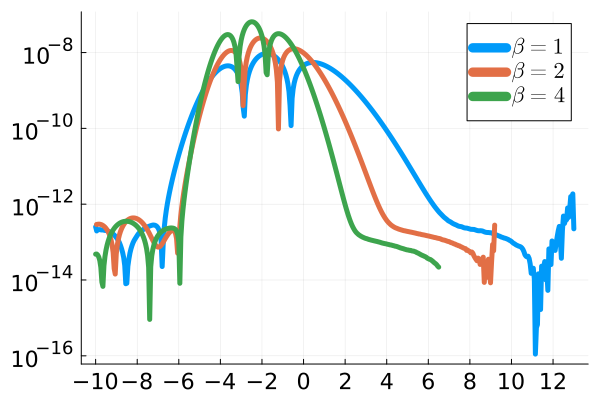

In [5]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
er_cdf22=err_cdf22(D1,D2,D4)

### Error plot with respect to $\left|\Delta x\right|$ and $M$

The following plots show how the absolute error (CDF) over the entire domain $x\in\left[-10,13/\sqrt{\beta}\right]$ changes when $\left|\Delta x\right|$ decreases for a fixed $\beta$-value. $\Delta x=-0.01,-0.005,-0.001$ and $M=8000$ are used.

In [6]:
function err_cdfc22(β,D)
    er_cdfc=Plots.plot();
    delta_x=[-0.01,-0.005,-0.001];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="TRBDF2",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.01$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.005$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.001$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return er_cdfc
end

err_cdfc22 (generic function with 1 method)

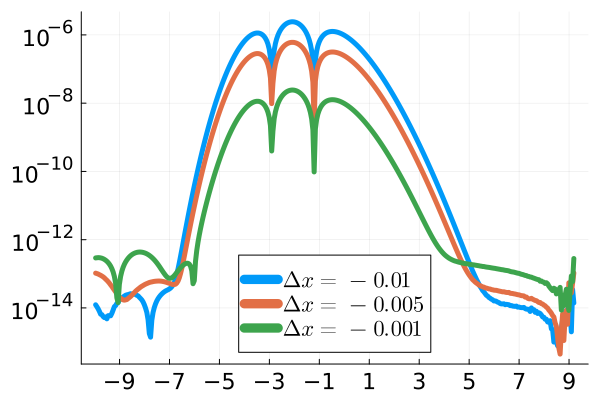

In [7]:
D=13/sqrt(2):-0.05:-10;
er_cdfc22=err_cdfc22(2,D)

### Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using TR-BDF2 for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.02,-0.01,-0.005$ are used.

In [8]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="TRBDF2",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [9]:
del_x=[-0.02,-0.01,-0.005];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="TRBDF2",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

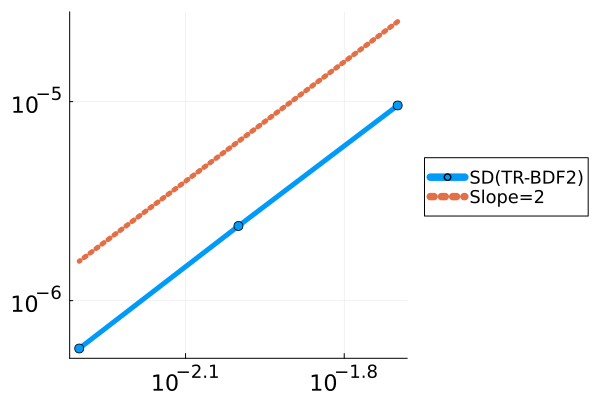

In [10]:
p=Plots.plot();
p=plot!(del_x.*(-1),vec(err),lw=5,label="SD(TR-BDF2)",legend=:outerright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=12)
p=plot!(del_x.*(-1),10^(-1.2)*(del_x.*(-1)).^(2),lw=5,label="Slope=2",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

For Crouzeix's A-stable two-stage third order diagonally implicit Runge–Kutta method:

$$
\begin{align*}
Y_{1}&=U^{n}+k\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)f\left(Y_{1},t_{n}+\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)k\right),\\
Y_{2}&=U^{n}+k\left[-\frac {\sqrt{3}}{3}f\left(Y_{1},t_{n}+\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)k\right)+\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)f\left(Y_{2},t_{n}+\left(\frac {1}{2}-\frac {\sqrt{3}}{6}\right)k\right)\right],\\
U^{n+1}&=U^{n}+k\left[\frac {1}{2}f\left(Y_{1},t_{n}+\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)k\right)+\frac {1}{2}f\left(Y_{2},t_{n}+\left(\frac {1}{2}-\frac {\sqrt{3}}{6}\right)k\right)\right],
\end{align*}
$$

we have

$$
\begin{align*}
Y_{1}&=\left[I-\Delta x\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)\left(A+\left(x_{n}+\Delta x\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)\right)B\right)\right]^{-1}\pmb{a}^{n}_{M},\\
Y_{2}&=\left[I-\Delta x\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)\left(A+\left(x_{n}+\Delta x\left(\frac {1}{2}-\frac {\sqrt{3}}{6}\right)\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}-\frac {\sqrt{3}}{3}\Delta x \left(A+\left(x_{n}+\Delta x\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)\right)B\right)Y_{1}\right],\\
\pmb{a}^{n+1}_{M}&=\pmb{a}^{n}_{M}+\Delta x\left[\frac {1}{2}\left(A+\left(x_{n}+\Delta x\left(\frac {1}{2}+\frac {\sqrt{3}}{6}\right)\right)B\right)Y_{1}+\frac {1}{2}\left(A+\left(x_{n}+\Delta x\left(\frac {1}{2}-\frac {\sqrt{3}}{6}\right)\right)B\right)Y_{2}\right].
\end{align*}
$$

In [11]:
@time TW_cdf = TW(2;method="spectral",step="irk23");

468.754021 seconds (5.64 M allocations: 875.542 GiB, 1.88% gc time)


### Error plot with respect to $\beta$

In [12]:
function err_cdf23(D1,D2,D4)
    er_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="irk23",Δx_f=-0.001)
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            er_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            er_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return er_cdf
end

err_cdf23 (generic function with 1 method)

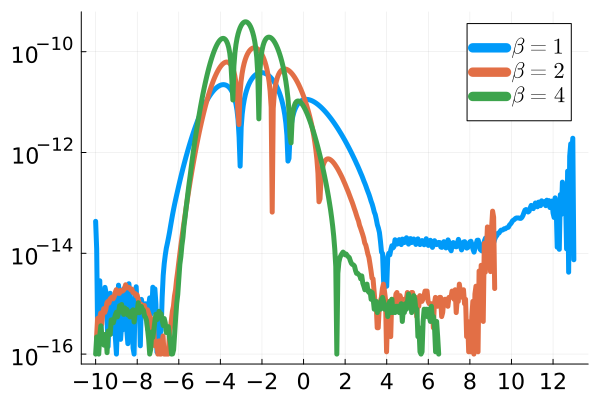

In [13]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
er_cdf23=err_cdf23(D1,D2,D4)

### Error plot with respect to $\left|\Delta x\right|$ and $M$

In [14]:
function err_cdfc23(β,D)
    er_cdfc=Plots.plot();
    delta_x=[-0.01,-0.005,-0.001];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="irk23",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.01$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.005$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.001$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return er_cdfc
end

err_cdfc23 (generic function with 1 method)

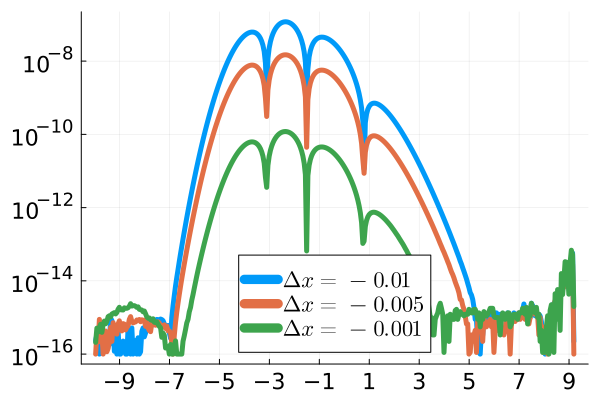

In [15]:
D=13/sqrt(2):-0.05:-10;
er_cdfc23=err_cdfc23(2,D)

### Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using Crouzeix's two-stage third order diagonally implicit Runge–Kutta method for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.02,-0.01,-0.005$ are used.

In [16]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk23",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [17]:
del_x=[-0.02,-0.01,-0.005];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk23",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

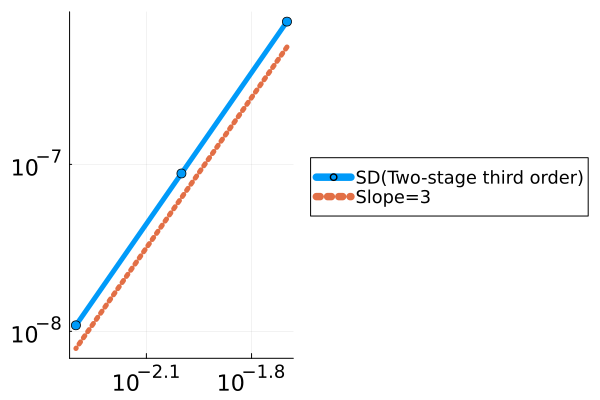

In [18]:
p1=Plots.plot();
p1=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Two-stage third order)",legend=:outerright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),
        10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),
        1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=12)
p1=plot!(del_x.*(-1),10^(-1.2)*(del_x.*(-1)).^(3),lw=5,label="Slope=3",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

For the three-stage third-order accurate L-stable diagonally implicit Runge-Kutta method:

$$
\begin{align*}
Y_{1}&=U^{n}+kxf\left(Y_{1},t_{n}+xk\right),\\
Y_{2}&=U^{n}+k\left[\frac {1-x}{2}f\left(Y_{1},t_{n}+xk\right)+xf\left(Y_{2},t_{n}+\frac {1+x}{2}k\right)\right],\\
Y_{3}&=U^{n}+k\left[\left(-\frac {3}{2}x^{2}+4x-\frac {1}{4}\right)f\left(Y_{1},t_{n}+xk\right)+\left(\frac {3}{2}x^2-5x+\frac {5}{4}\right)f\left(Y_{2},t_{n}+\frac {1+x}{2}k\right)+xf\left(Y_{3},t_{n}+k\right)\right],\\
U^{n+1}&=Y_{3}=U^{n}+k\left[\left(-\frac {3}{2}x^{2}+4x-\frac {1}{4}\right)f\left(Y_{1},t_{n}+xk\right)+\left(\frac {3}{2}x^2-5x+\frac {5}{4}\right)f\left(Y_{2},t_{n}+\frac {1+x}{2}k\right)+xf\left(Y_{3},t_{n}+k\right)\right],
\end{align*}
$$

where $x=0.4358665215$,

we have

$$
\begin{align*}
Y_{1}&=\left[I-x\Delta x\left(A+\left(x_{n}+x\Delta x\right)B\right)\right]^{-1}\pmb{a}^{n}_{M},\\
Y_{2}&=\left[I-x\Delta x\left(A+\left(x_{n}+\left(\frac {1+x}{2}\right)\Delta x\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+\Delta x\left(\frac {1-x}{2}\right)\left(A+\left(x_{n}+x\Delta x\right)B\right)Y_{1}\right],\\
\pmb{a}^{n+1}_{M}&=\left[I-x\Delta x\left(A+x_{n+1}B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+\Delta x\left(-\frac {3}{2}x^{2}+4x-\frac {1}{4}\right)\left(A+\left(x_{n}+x\Delta x\right)B\right)Y_{1}+\Delta x\left(\frac {3}{2}x^2-5x+\frac {5}{4}\right)\left(A+\left(x_{n}+\left(\frac {1+x}{2}\right)\Delta x\right)B\right)Y_{2}\right],
\end{align*}
$$

where $x=0.4358665215$.

In [19]:
@time TW_cdf = TW(2;method="spectral",step="irk33");

754.034474 seconds (7.79 M allocations: 1.192 TiB, 1.67% gc time)


### Error plot with respect to $\beta$

In [20]:
function err_cdf33(D1,D2,D4)
    er_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="irk33",Δx_f=-0.001)
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            er_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            er_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return er_cdf
end

err_cdf33 (generic function with 1 method)

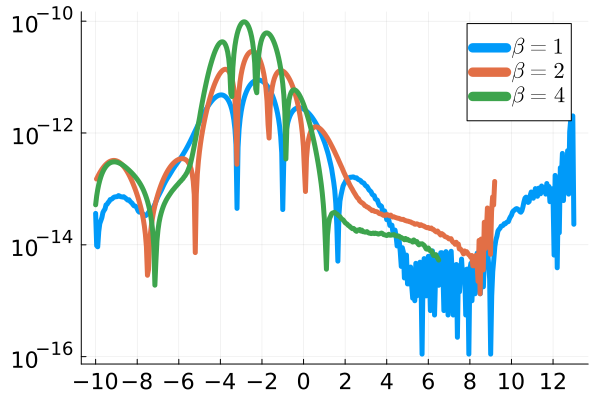

In [21]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
er_cdf33=err_cdf33(D1,D2,D4)

### Error plot with respect to $\left|\Delta x\right|$ and $M$

In [22]:
function err_cdfc33(β,D)
    er_cdfc=Plots.plot();
    delta_x=[-0.01,-0.005,-0.001];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="irk33",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.01$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.005$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.001$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return er_cdfc
end

err_cdfc33 (generic function with 1 method)

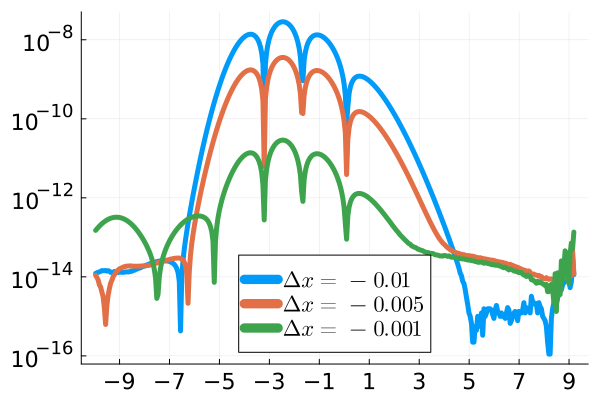

In [23]:
D=13/sqrt(2):-0.05:-10;
er_cdfc33=err_cdfc33(2,D)

### Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using the three-stage third-order accurate L-stable diagonally implicit Runge-Kutta method for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.02,-0.01,-0.005$ are used.

In [24]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk33",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [25]:
del_x=[-0.02,-0.01,-0.005];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk33",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

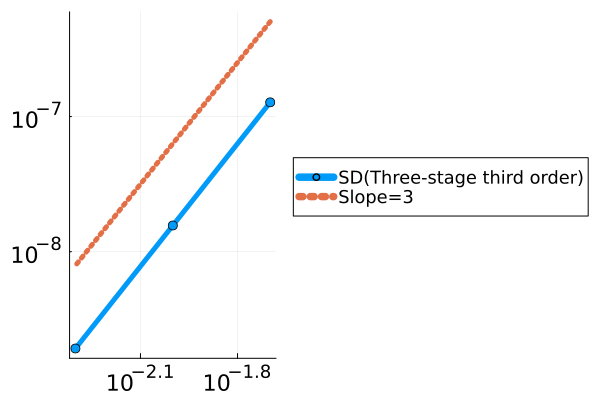

In [26]:
p2=Plots.plot();
p2=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Three-stage third order)",legend=:outerright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),
        10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),
        1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=12)
p2=plot!(del_x.*(-1),10^(-1.2)*(del_x.*(-1)).^(3),lw=5,label="Slope=3",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

For the four-stage third-order accurate L-stable diagonally implicit Runge-Kutta method:

$$
\begin{align*}
Y_{1}&=U^{n}+\frac {k}{2}f\left(Y_{1},t_{n}+\frac {k}{2}\right),\\
Y_{2}&=U^{n}+k\left[\frac {1}{6}f\left(Y_{1},t_{n}+\frac {k}{2}\right)+\frac {1}{2}f\left(Y_{2},t_{n}+\frac {2k}{3}\right)\right],\\
Y_{3}&=U^{n}+k\left[-\frac {1}{2}f\left(Y_{1},t_{n}+\frac {k}{2}\right)+\frac {1}{2}f\left(Y_{2},t_{n}+\frac {2k}{3}\right)+\frac {1}{2}f\left(Y_{3},t_{n}+\frac {k}{2}\right)\right],\\
Y_{4}&=U^{n}+k\left[\frac {3}{2}f\left(Y_{1},t_{n}+\frac {k}{2}\right)-\frac {3}{2}f\left(Y_{2},t_{n}+\frac {2k}{3}\right)+\frac {1}{2}f\left(Y_{3},t_{n}+\frac {k}{2}\right)+\frac {1}{2}f\left(Y_{4},t_{n}+k\right)\right],\\
U^{n+1}&=Y_{4}=U^{n}+k\left[\frac {3}{2}f\left(Y_{1},t_{n}+\frac {k}{2}\right)-\frac {3}{2}f\left(Y_{2},t_{n}+\frac {2k}{3}\right)+\frac {1}{2}f\left(Y_{3},t_{n}+\frac {k}{2}\right)+\frac {1}{2}f\left(Y_{4},t_{n}+k\right)\right],
\end{align*}
$$

we have

$$
\begin{align*}
Y_{1}&=\left[I-\frac {\Delta x}{2}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)\right]^{-1}\pmb{a}^{n}_{M},\\
Y_{2}&=\left[I-\frac {\Delta x}{2}\left(A+\left(x_{n}+\frac {2\Delta x}{3}\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+\frac {\Delta x}{6}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)Y_{1}\right],\\
Y_{3}&=\left[I-\frac {\Delta x}{2}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}-\frac {\Delta x}{2}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)Y_{1}+\frac {\Delta x}{2}\left(A+\left(x_{n}+\frac {2\Delta x}{3}\right)B\right)Y_{2}\right],\\
\pmb{a}^{n+1}_{M}&=\left[I-\frac {\Delta x}{2}\left(A+x_{n+1}B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+\frac {3\Delta x}{2}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)Y_{1}-\frac {3\Delta x}{2}\left(A+\left(x_{n}+\frac {2\Delta x}{3}\right)B\right)Y_{2}+\frac {\Delta x}{2}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)Y_{3}\right].
\end{align*}
$$

In [27]:
@time TW_cdf = TW(2;method="spectral",step="irk43");

1350.280348 seconds (11.02 M allocations: 1.669 TiB, 2.14% gc time)


### Error plot with respect to $\beta$

In [28]:
function err_cdf43(D1,D2,D4)
    er_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="irk43",Δx_f=-0.001)
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            er_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            er_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return er_cdf
end

err_cdf43 (generic function with 1 method)

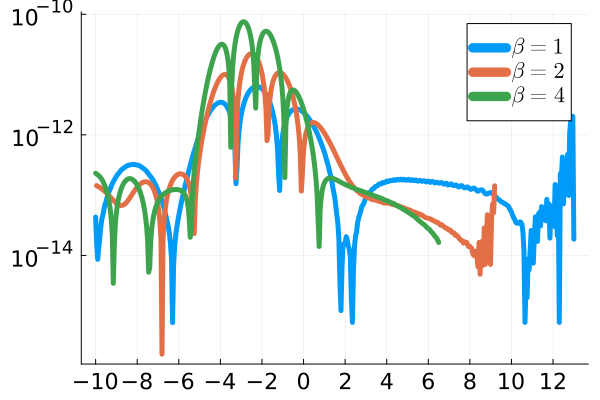

In [29]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
er_cdf43=err_cdf43(D1,D2,D4)

### Error plot with respect to $\left|\Delta x\right|$ and $M$

In [30]:
function err_cdfc43(β,D)
    er_cdfc=Plots.plot();
    delta_x=[-0.01,-0.005,-0.001];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="irk43",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.01$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.005$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.001$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return er_cdfc
end

err_cdfc43 (generic function with 1 method)

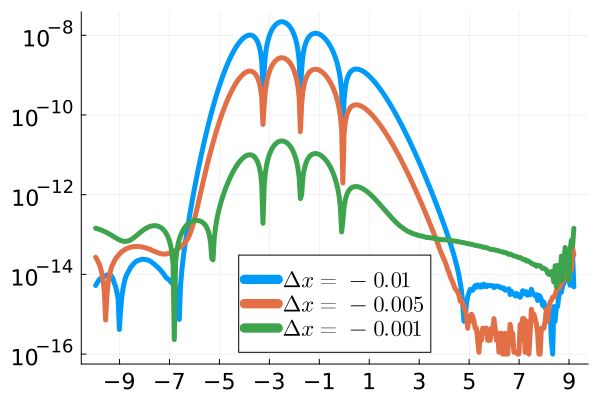

In [31]:
D=13/sqrt(2):-0.05:-10;
er_cdfc43=err_cdfc43(2,D)

### Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using the four-stage third-order accurate L-stable diagonally implicit Runge-Kutta method for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.02,-0.01,-0.005$ are used.

In [32]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk43",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [33]:
del_x=[-0.02,-0.01,-0.005];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk43",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

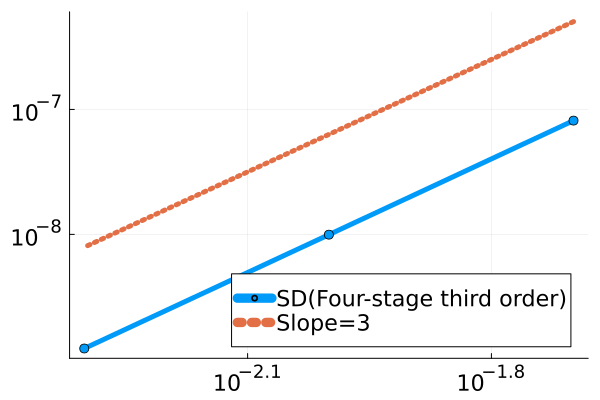

In [34]:
p3=Plots.plot();
p3=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Four-stage third order)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),
        10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),
        1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
p3=plot!(del_x.*(-1),10^(-1.2)*(del_x.*(-1)).^(3),lw=5,label="Slope=3",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

For Crouzeix's strong A-stable three-stage fourth-order diagonally implicit Runge–Kutta method:

$$
\begin{align*}
Y_{1}&=U^{n}+k\left(\frac {1+\alpha}{2}\right)f\left(Y_{1},t_{n}+\frac {1+\alpha}{2}k\right),\\
Y_{2}&=U^{n}+k\left[-\frac {\alpha}{2}f\left(Y_{1},t_{n}+\frac {1+\alpha}{2}k\right)+\frac {1+\alpha}{2}f\left(Y_{2},t_{n}+\frac {k}{2}\right)\right],\\
Y_{3}&=U^{n}+k\left[(1+\alpha)f\left(Y_{1},t_{n}+\frac {1+\alpha}{2}k\right)-(1+2\alpha)f\left(Y_{2},t_{n}+\frac {k}{2}\right)+\frac {1+\alpha}{2}f\left(Y_{3},t_{n}+\frac {1-\alpha}{2}k\right)\right],\\
U^{n+1}&=U^{n}+k\left[\frac {1}{6\alpha^{2}}f\left(Y_{1},t_{n}+\frac {1+\alpha}{2}k\right)+\left(1-\frac {1}{3\alpha^2}\right)f\left(Y_{2},t_{n}+\frac {k}{2}\right)+\frac {1}{6\alpha^2}f\left(Y_{3},t_{n}+\frac {1-\alpha}{2}k\right)\right],
\end{align*}
$$

where $\alpha=\frac {2}{\sqrt{3}}\cos \frac {\pi}{18}$,

we have

$$
\begin{align*}
Y_{1}&=\left[I-\Delta x\left(\frac {1+\alpha}{2}\right)\left(A+\left(x_{n}+\left(\frac {1+\alpha}{2}\right)\Delta x\right)B\right)\right]^{-1}\pmb{a}^{n}_{M},\\
Y_{2}&=\left[I-\frac {1+\alpha}{2}\Delta x\left(A+\left(x_{n}+\left(\frac {\Delta x}{2}\right)\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}-\frac {\alpha}{2}\Delta x \left(A+\left(x_{n}+\left(\frac {1+\alpha}{2}\right)\Delta x\right)B\right)Y_{1}\right],\\
Y_{3}&=\left[I-\frac {1+\alpha}{2}\Delta x \left(A+\left(x_{n}+\left(\frac {1-\alpha}{2}\right)\Delta x\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+\Delta x (1+\alpha)\left(A+\left(x_{n}+\left(\frac {1+\alpha}{2}\right)\Delta x\right)B\right)Y_{1}-\Delta x(1+2\alpha)\left(A+\left(x_{n}+\left(\frac {\Delta x}{2}\right)\right)B\right)Y_{2}\right],\\
\pmb{a}^{n+1}_{M}&=\pmb{a}^{n}_{M}+\frac {\Delta x}{6\alpha^2}\left(A+\left(x_{n}+\left(\frac {1+\alpha}{2}\right)\Delta x\right)B\right)Y_{1}+\Delta x\left(1-\frac {1}{3\alpha^2}\right)\left(A+\left(x_{n}+\left(\frac {\Delta x}{2}\right)\right)B\right)Y_{2}+\frac {\Delta x}{6\alpha^2}\left(A+\left(x_{n}+\left(\frac {1-\alpha}{2}\right)\Delta x\right)B\right)Y_{3},
\end{align*}
$$

where $\alpha=\frac {2}{\sqrt{3}}\cos \frac {\pi}{18}$.

In [49]:
@time TW_cdf = TW(2;method="spectral",step="irk34");

782.963875 seconds (8.79 M allocations: 1.327 TiB, 3.78% gc time)


### Error plot with respect to $\beta$

In [35]:
function err_cdf34(D1,D2,D4)
    er_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="irk34",Δx_f=-0.001)
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            er_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            er_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return er_cdf
end

err_cdf34 (generic function with 1 method)

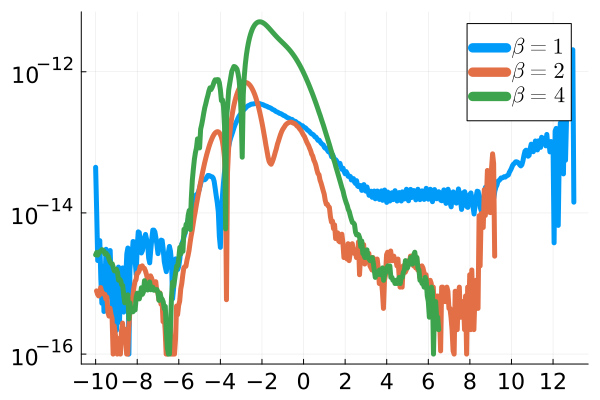

In [36]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
er_cdf34=err_cdf34(D1,D2,D4)

### Error plot with respect to $\left|\Delta x\right|$ and $M$

In [37]:
function err_cdfc34(β,D)
    er_cdfc=Plots.plot();
    delta_x=[-0.01,-0.005,-0.001];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="irk34",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.01$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.005$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.001$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return er_cdfc
end

err_cdfc34 (generic function with 1 method)

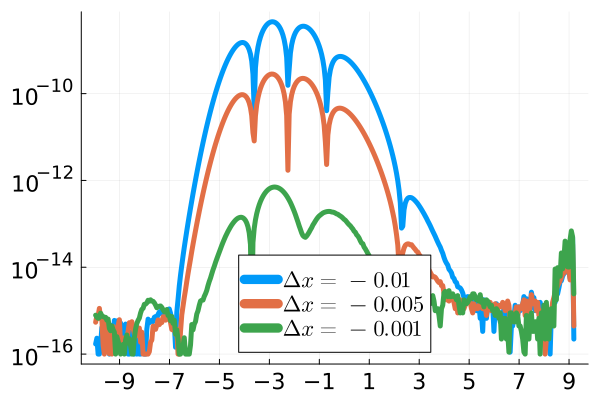

In [38]:
D=13/sqrt(2):-0.05:-10;
er_cdfc34=err_cdfc34(2,D)

### Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using Crouzeix's three-stage fourth-order accurate strong A-stable diagonally implicit Runge-Kutta method for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.02,-0.01,-0.005$ are used.

In [39]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk34",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [40]:
del_x=[-0.02,-0.01,-0.005];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irk34",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

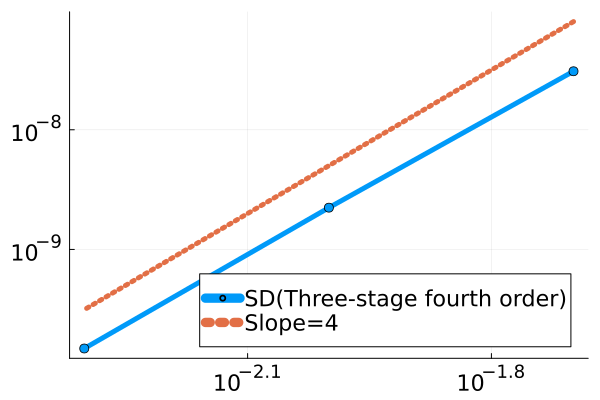

In [41]:
p4=Plots,plot();
p4=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Three-stage fourth order)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),
        10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),
        1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
p4=plot!(del_x.*(-1),10^(-0.3)*(del_x.*(-1)).^(4),lw=5,label="Slope=4",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)

For Nørsett's A-stable three-stage fourth-order diagonally implicit Runge–Kutta method:

$$
\begin{align*}
Y_{1}&=U^{n}+kxf\left(Y_{1},t_{n}+xk\right),\\
Y_{2}&=U^{n}+k\left[\left(\frac {1}{2}-x\right)f\left(Y_{1},t_{n}+xk\right)+xf\left(Y_{2},t_{n}+\frac {k}{2}\right)\right],\\
Y_{3}&=U^{n}+k\left[2xf\left(Y_{1},t_{n}+xk\right)+(1-4x)f\left(Y_{2},t_{n}+\frac {k}{2}\right)+xf\left(Y_{3},t_{n}+(1-x)k\right)\right],\\
U^{n+1}&=U^{n}+k\left[\frac {1}{6(1-2x)^2}f\left(Y_{1},t_{n}+xk\right)+\frac {3(1-2x)^2-1}{3(1-2x)^2}f\left(Y_{2},t_{n}+\frac {k}{2}\right)+\frac {1}{6(1-2x)^2}f\left(Y_{3},t_{n}+(1-x)k\right)\right],
\end{align*}
$$

where $x=1.06858$,

we have

$$
\begin{align*}
Y_{1}&=\left[I-x\Delta x \left(A+\left(x_{n}+x\Delta x\right)B\right)\right]^{-1}\pmb{a}^{n}_{M},\\
Y_{2}&=\left[I-x\Delta x\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+\left(\frac {1}{2}-x\right)\Delta x\left(A+\left(x_{n}+x\Delta x\right)B\right)Y_{1}\right],\\
Y_{3}&=\left[I-x\Delta x\left(A+\left(x_{n}+(1-x)\Delta x\right)B\right)\right]^{-1}\left[\pmb{a}^{n}_{M}+2x\Delta x\left(A+\left(x_{n}+x\Delta x\right)B\right)Y_{1}+(1-4x)\Delta x\left(A+\left(x_{n}+\frac {k}{2}\right)B\right)Y_{2}\right],\\
\pmb{a}^{n+1}_{M}&=\pmb{a}^{n}_{M}+\frac {\Delta x}{6(1-2x)^2}\left(A+\left(x_{n}+x\Delta x\right)B\right)Y_{1}+\Delta x\frac {3(1-2x)^2-1}{3(1-2x)^2}\left(A+\left(x_{n}+\frac {\Delta x}{2}\right)B\right)Y_{2}+\frac {\Delta x}{6(1-2x)^2}\left(A+\left(x_{n}+\Delta x(1-x)\right)B\right)Y_{3},
\end{align*}
$$

where $x=1.06858$.

In [50]:
@time TW_cdf = TW(2;method="spectral",step="irkn34");

794.563207 seconds (8.83 M allocations: 1.341 TiB, 3.95% gc time)


### Error plot with respect to $\beta$

In [42]:
function err_cdfn34(D1,D2,D4)
    er_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="irkn34",Δx_f=-0.001)
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            er_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            er_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return er_cdf
end

err_cdfn34 (generic function with 1 method)

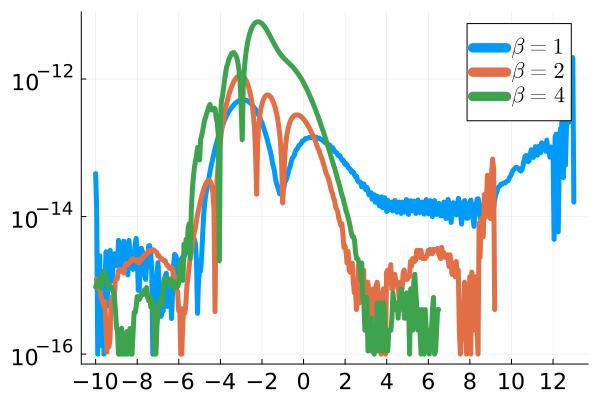

In [43]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
er_cdfn34=err_cdfn34(D1,D2,D4)

### Error plot with respect to $\left|\Delta x\right|$ and $M$

In [44]:
function err_cdfcn34(β,D)
    er_cdfc=Plots.plot();
    delta_x=[-0.01,-0.005,-0.001];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="irkn34",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.01$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.005$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            er_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.001$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-3),10^(-2)],
                xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return er_cdfc
end

err_cdfcn34 (generic function with 1 method)

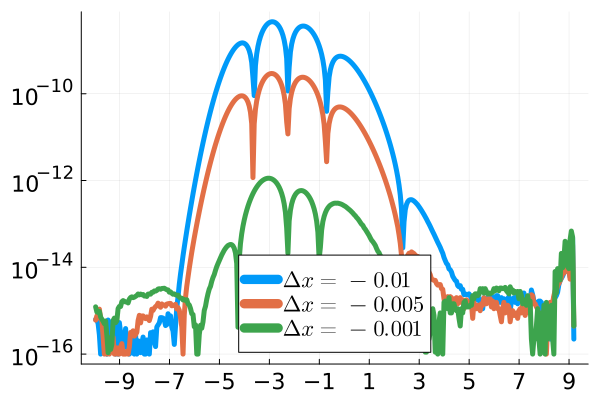

In [45]:
D=13/sqrt(2):-0.05:-10;
er_cdfcn34=err_cdfcn34(2,D)

### Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using Nørsett's three-stage fourth-order method for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.02,-0.01,-0.005$ are used.

In [46]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irkn34",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [47]:
del_x=[-0.02,-0.01,-0.005];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="irkn34",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

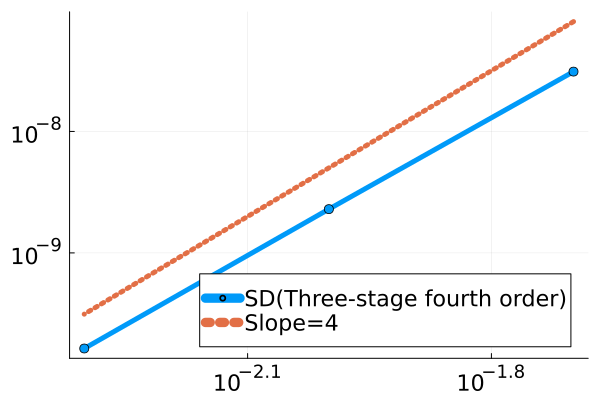

In [48]:
p5=Plots,plot();
p5=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Three-stage fourth order)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),
        10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),
        1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
p5=plot!(del_x.*(-1),10^(-0.3)*(del_x.*(-1)).^(4),lw=5,label="Slope=4",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:bottomright)